In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Build a class of Hierarchical Cluster

In [126]:
import numpy as np
from scipy.spatial import distance_matrix

class HierarchicalCluster():
    def __init__(self, data, method='single'):
        """
        input
        -----
        data: data should be a two dimension array with shape = (M, N). 
              M represent to number of observation data, and N represent to data dimensional.
        method: type of string. it can be 'single', 'complete', 'average', or 'centroid'.
        """
        # check data dimension
        if len(data.shape) != 2:
            raise ValueError('data must be 2 dimensional.')
        else:
            self.data = data
        
        # check method
        if method not in ['single', 'complete', 'average', 'centroid', 'ward']:
            raise Exception(
                'Invalid method "{}". Shoule be "single", "complete", "average", "centroid" or "ward".'.format(method))
        else:
            self.method = method
            
        # creat a dictionary to store the history of clusters evolution
        self.clusters = {}
        
        # "rmsttd", "rs" and "spr" would be a array with len = (N-1) after "fit" has been used.
        self.rmsstd = np.nan
        self.rs = np.nan
        self.spr = np.nan
    
    
    def __single_linkage(slef, cl1, cl2):
        """
        cl1 and cl2 should be two dimensional array.

        EX:
        cl1 = np.array([[1, 2],
                        [3, 4]])
        cl2 = np.array([[2, 4],
                        [5, 1]])
        then self.__single_linkage(cl1, cl2) = 1.0
        because the distance between [1, 2] and [2, 4] is sqrt(5)
        between [1, 2] and [5, 1] is sqrt(17)
        between [3, 4] and [2, 4] is 1.0
        between [3, 4] and [5, 1] is sqrt(13),
        thus the single linkage method is 1.0
        """
        return distance_matrix(cl1, cl2).min()
    
    
    def __complete_linkage(self, cl1, cl2):
        """
        cl1 and cl2 should be two dimensional array
        """
        return distance_matrix(cl1, cl2).max()
    
    
    def __average_linkage(self, cl1, cl2):
        """
        cl1 and cl2 should be two dimensional array
        """
        return distance_matrix(cl1, cl2).mean()
    
    
    def __centroid_method(self, cl1, cl2):
        """
        cl1 and cl2 should be two dimensional array
        """
        #return distance_matrix(cl1.mean(axis=0)[np.newaxis, :], cl2.mean(axis=0)[np.newaxis, :])[0][0]
        # above way can work excatly, but I prefer to the way below because of the readabillity
        
        # get mean coordinate of cl1, cl2 and transfer them to two dimention (1, N)
        cl1_mean = cl1.mean(axis=0)[np.newaxis, :]
        cl2_mean = cl2.mean(axis=0)[np.newaxis, :]
        return np.sqrt(((cl1_mean - cl2_mean) ** 2).sum())
    
    
    def __ward(self, cl1, cl2):
        """
        cl1 and cl2 should be two dimensional array
        
        use the Lance–Williams algorithms
        formula: https://wikimedia.org/api/rest_v1/media/math/render/svg/a9a1b598cb084bc677269e164fedd1380c55d52e
        from Ward's method of wiki
        """
        if len(cl1.shape) == 1:
            cl1 = cl1[np.newaxis, :]
        elif len(cl2.shape) == 1:
            cl2 = cl2[np.newaxis, :]

        if cl1.shape[0] != 1:
            nk = cl2.shape[0]
            ni = cl1[1:].shape[0]
            nj = cl1[[0]].shape[0]
            a1 = (nk + ni) / (nk + ni + nj)
            a2 = (nk + nj) / (nk + ni + nj)
            g = nk / (nk + ni + nj)
            return np.sqrt(a1 * ward(cl1[1:], cl2)**2 + a2 * ward(cl1[[0]], cl2)**2 - g * ward(cl1[1:], cl1[[0]])**2)
        elif cl2.shape[0] != 1:
            nk = cl1.shape[0]
            ni = cl2[1:].shape[0]
            nj = cl2[[0]].shape[0]
            a1 = (nk + ni) / (nk + ni + nj)
            a2 = (nk + nj) / (nk + ni + nj)
            g = nk / (nk + ni + nj)
            return np.sqrt(a1 * ward(cl1, cl2[1:])**2 + a2 * ward(cl1, cl2[[0]])**2 - g * ward(cl2[1:], cl2[[0]])**2)
        else:
            return np.sqrt(((cl1 - cl2) ** 2).sum())
    
    
    def __RMSSTD(slef, cl1, cl2):
        """
        claculate root-mean-square-total-sample standard deviation, RMSSTD.
        
        cl1 and cl2 should be two dimensional array
        """
        new_clu = np.vstack((cl1, cl2))
        ndegree = new_clu.shape[0] - 1
        return np.sqrt(((new_clu - new_clu.mean(axis=0)) ** 2).sum() / (2 * ndegree))
    
    
    def __RS(self, cls, all_data):
        """
        calculate R-Squared.
        
        cls: a list of two-dimensional array. elements in list means all clusters, 
             and every 2-d array means datas in a cluster
        all_data: all data

        EX:
        cls = [np.array([[5, 5], [6, 6]]), np.array([[15, 14], [16, 15], [25, 20], [30, 19]])]
        data = np.array([[5, 5], [6, 6], [15, 14], [16, 15], [25, 20], [30, 19]])
        RS(cls, data)
        >> 0.7377
        """
        SSw = 0
        for c in cls:
            SSw += ((c - c.mean(axis=0)) ** 2).sum()

        SSt = ((all_data - all_data.mean(axis=0)) ** 2).sum()

        return 1 - SSw/SSt
    
    
    def __SPR(self, old_cl1, old_cl2, all_data):
        """
        calculate semipartial R-squared

        Parameters
        ----------
        old_cl1, old_cl2: two old clusters which form the new cluster. they should be 1- 
                          or 2-d array. if 2-d, shape[0] means the number of datas in
                          the cluster, and shape[1] means the dimension.
                          if 1-d, it means that there is only one data in the cluster, and
                          the shape means the dimention
        all_data: all data

        EX:
        old1 = np.array([[15, 14], [16, 15]])
        old2 = np.array([[25, 20], [30, 19]])
        data = np.array([[5, 5], [6, 6], [15, 14], [16, 15], [25, 20], [30, 19]])
        SPR(old1, old2, data)
        >>> 0.2409
        """
        new_cl = np.vstack((old_cl1, old_cl2))
        
        new_ssw = ((new_cl - new_cl.mean(axis=0)) ** 2).sum()
        old1_ssw = ((old_cl1 - old_cl1.mean(axis=0)) ** 2).sum()
        old2_ssw = ((old_cl2 - old_cl2.mean(axis=0)) ** 2).sum()

        SSt = ((all_data - all_data.mean(axis=0)) ** 2).sum()

        return (new_ssw - (old1_ssw+old2_ssw)) / SSt
    
    
    def __CD(self, cl1, cl2, ward=False):
        """
        calculate Centroid Distance
        
        Parameters
        ----------
        cl1, cl2: two old clusters which form the new cluster. they should be 2-d
                  array, shape[0] means the number of datas in the cluster, and 
                  shape[1] means the dimension.
        ward: boolen. to determine whether the clusters are connected by ward's method.
              default is False.
        
        EX:
        cl1 = np.array([[15, 14], [16, 15]])
        cl2 = np.array([[25, 20], [30, 19]])
        CD(cl1, cl2)
        >> 13.0
        """
        if len(cl1.shape) == 1:
            cl1 = cl1[np.newaxis, :]
        elif len(cl2.shape) == 1:
            cl2 = cl2[np.newaxis, :]
        
        if not ward:
            centroid_cl1 = cl1.mean(axis=0)
            centroid_cl2 = cl2.mean(axis=0)
            return np.sqrt(((centroid_cl1 - centroid_cl2) ** 2).sum())
        else:
            n1 = cl1.shape[0]
            n2 = cl2.shape[0]
            cl_new = np.vstack((cl1, cl2))

            cl1_dist_mean = ((cl1.mean(axis=0)-cl_new.mean(axis=0)) ** 2).sum()
            cl2_dist_mean = ((cl2.mean(axis=0)-cl_new.mean(axis=0)) ** 2).sum()
            return np.sqrt(n1 * cl1_dist_mean + n2 * cl2_dist_mean)
        
        
    def fit(self, iter_info=True):
        # decide which method would be use in determination the distance of two clusters
        if self.method == 'single':
            dist_func = self.__single_linkage
        elif self.method == 'complete':
            dist_func = self.__complete_linkage
        elif self.method == 'average':
            dist_func = self.__average_linkage
        elif self.method == 'centroid':
            dist_func = self.__centroid_method
        elif self.method == 'ward':
            dist_func = self.__ward
        
        # the return matrix "Z"
        # 4 cols represent the two clusters which form the new cluster, their distance, and number of elements
        Z = np.zeros((self.data.shape[0]-1, 4))
        
        # the RMSSTD, RS, SPR and CD of each iteration
        self.rmsstd = np.zeros(Z.shape[0])
        self.rs = np.zeros(Z.shape[0])
        self.spr = np.zeros(Z.shape[0])
        self.cd = np.zeros(Z.shape[0])
        
        # make a dictionary to store every historical clusters element. and initial clusters is the elements of data
        clusters = {'CL' + str(i): [i] for i in range(self.data.shape[0])}
        
        
        # do the first clustering
        data = self.data.copy()
        dma = distance_matrix(data, data)
        dma[dma == 0] = np.nan
        ## find the distance "min_dist" and the couple of clusters "min_dist_cl" which has the minimum distance
        min_dist = np.nanmin(dma)
        min_dist_cl = np.unravel_index(np.nanargmin(dma), dma.shape)
        
        ## update Z
        Z[0, :] = np.array([min_dist_cl[0], min_dist_cl[1], min_dist, 2])
        ## update clusters dictionary
        clusters['CL' + str(self.data.shape[0])] = [min_dist_cl[0], min_dist_cl[1]]
        ## creat "cl_now" to store all the clusters now after new cluster having formed
        cl_now = ([[min_dist_cl[0], min_dist_cl[1]]] + 
                   [[i] for i in range(self.data.shape[0]) if i != int(min_dist_cl[0]) and i != int(min_dist_cl[1])])
        ## update self.rmsttd, self.rs, self.spr and self.cd
        self.rmsstd[0] = self.__RMSSTD(self.data[min_dist_cl[0]], self.data[min_dist_cl[1]])
        self.rs[0] = self.__RS([self.data[cn] for cn in cl_now], self.data)
        self.spr[0] = self.__SPR(self.data[min_dist_cl[0]], self.data[min_dist_cl[1]], self.data)
        self.cd[0] = self.__CD(self.data[min_dist_cl[0]], self.data[min_dist_cl[1]])
        
        ## print iterate information
        if iter_info:
            print('Step 0:')
            print('clusters:\n', clusters)
            print('cl_now:\n', cl_now)
            print('Z:\n', Z)
        
        
        # do the remain clustering
        for i in range(self.data.shape[0]-2):
            ## find the minimum distance between all clusters in "cl_now"
            min_dist = dist_func(self.data[cl_now[0]], self.data[cl_now[1]])
            min_dist_cl = [cl_now[0], cl_now[1]]
            for j in range(len(cl_now)):
                for k in range(j+1, len(cl_now)):
                    if dist_func(self.data[cl_now[j]], self.data[cl_now[k]]) < min_dist:
                        min_dist = dist_func(self.data[cl_now[j]], self.data[cl_now[k]])
                        min_dist_cl = [cl_now[j], cl_now[k]]
            
            ## update the clusters dictionary "clusters". min_dist_cl[0] and min_dist_cl[1] form "new_from_cluster"
            new_form_cluster = sorted([l for sublist in min_dist_cl for l in sublist])
            clusters['CL' + str(i + 1 + self.data.shape[0])] = new_form_cluster
            
            ## update the clusters now "cl_now"
            cl_now.remove(min_dist_cl[0])
            cl_now.remove(min_dist_cl[1])
            cl_now.append(new_form_cluster)
            
            ## update Z
            ### 1. find the cluster id of "min_dist_cl"
            for clid, cls in clusters.items():
                if cls == min_dist_cl[0]:
                    id1 = float(clid[2:])
                elif cls == min_dist_cl[1]:
                    id2 = float(clid[2:])
            ### 2. update Z
            Z[i+1, :] = np.array([id1, id2, min_dist, len(clusters['CL' + str(self.data.shape[0] + i + 1)])])
            
            ## update RMSSTD, RS, SPR and CD
            self.rmsstd[i+1] = self.__RMSSTD(self.data[min_dist_cl[0]], self.data[min_dist_cl[1]])
            self.rs[i+1] = self.__RS([self.data[cn] for cn in cl_now], self.data)
            self.spr[i+1] = self.__SPR(self.data[min_dist_cl[0]], self.data[min_dist_cl[1]], self.data)
            self.cd[i+1] = self.__CD(self.data[min_dist_cl[0]], self.data[min_dist_cl[1]])
            
            ## print iterate information
            if iter_info:
                print('\nStep {}'.format(i + 1))
                print('clusters:\n', clusters)
                print('cl_now:\n', cl_now)
                print('Z:\n', Z)
                
        self.clusters = clusters
        return Z

### test this class and compare to scipy

In [127]:
data = np.array([
    [5, 5],
    [6, 6],
    [15, 14],
    [16, 15],
    [25, 20],
    [30, 19]
])

data

array([[ 5,  5],
       [ 6,  6],
       [15, 14],
       [16, 15],
       [25, 20],
       [30, 19]])

In [128]:
h = HierarchicalCluster(data, method='ward')
h.fit(iter_info=False)

array([[ 0.        ,  1.        ,  1.41421356,  2.        ],
       [ 2.        ,  3.        ,  1.41421356,  2.        ],
       [ 4.        ,  5.        ,  5.09901951,  2.        ],
       [ 7.        ,  8.        , 18.38477631,  4.        ],
       [ 6.        ,  9.        , 32.17659605,  6.        ]])

In [120]:
from scipy.cluster import hierarchy

hierarchy.linkage(data, 'ward')

array([[ 0.        ,  1.        ,  1.41421356,  2.        ],
       [ 2.        ,  3.        ,  1.41421356,  2.        ],
       [ 4.        ,  5.        ,  5.09901951,  2.        ],
       [ 7.        ,  8.        , 18.38477631,  4.        ],
       [ 6.        ,  9.        , 32.17659605,  6.        ]])

In [121]:
print('RMSSTD: ', h.rmsstd)
print('RS:     ', h.rs)
print('SPR:    ', h.spr)
print('CD:     ', h.cd)

RMSSTD:  [0.70710678 0.70710678 2.54950976 5.52268051 8.37655458]
RS:      [0.99857482 0.99714964 0.97862233 0.73776722 0.        ]
SPR:     [0.00142518 0.00142518 0.01852732 0.24085511 0.73776722]
CD:      [ 1.41421356  1.41421356  5.09901951 13.         19.7040605 ]


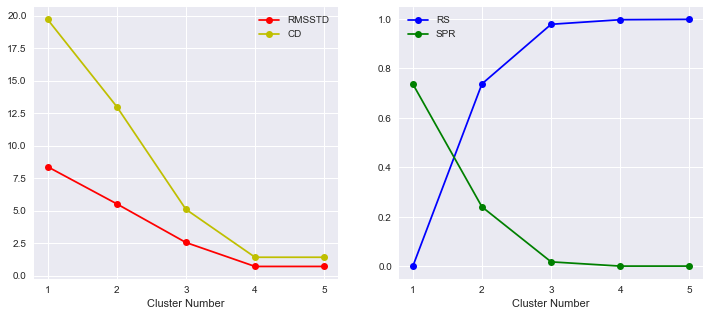

In [122]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

x = np.array([1, 2, 3, 4, 5])
ax[0].plot(x, h.rmsstd[::-1], 'ro-', label='RMSSTD')
ax[0].plot(x, h.cd[::-1], 'yo-', label='CD')
ax[0].legend(loc='best')
ax[0].set_xticks(np.arange(1, 6, 1))
ax[0].set_xlabel('Cluster Number')

ax[1].plot(x, h.rs[::-1], 'bo-', label='RS')
ax[1].plot(x, h.spr[::-1], 'go-', label='SPR')
ax[1].legend(loc='best')
ax[1].set_xticks(np.arange(1, 6, 1))
ax[1].set_xlabel('Cluster Number');

In [8]:
# 還差ward法，還有補上CD的ward部分

In [114]:
def ward(cl1, cl2):
    """
    cl1 and cl2 should be two dimensional array
    """
    if len(cl1.shape) == 1:
        cl1 = cl1[np.newaxis, :]
    elif len(cl2.shape) == 1:
        cl2 = cl2[np.newaxis, :]

    if cl1.shape[0] != 1:
        v = cl2.shape[0]
        s = cl1[1:].shape[0]
        t = cl1[[0]].shape[0]
        a1 = (v + s) / (v + s + t)
        a2 = (v + t) / (v + s + t)
        g = v / (v + s + t)
        return np.sqrt(a1 * ward(cl1[1:], cl2)**2 + a2 * ward(cl1[[0]], cl2)**2 - g * ward(cl1[1:], cl1[[0]])**2)
    elif cl2.shape[0] != 1:
        v = cl1.shape[0]
        s = cl2[1:].shape[0]
        t = cl2[[0]].shape[0]
        a1 = (v + s) / (v + s + t)
        a2 = (v + t) / (v + s + t)
        g = v / (v + s + t)
        return np.sqrt(a1 * ward(cl1, cl2[1:])**2 + a2 * ward(cl1, cl2[[0]])**2 - g * ward(cl2[1:], cl2[[0]])**2)
    else:
        return np.sqrt(((cl1 - cl2) ** 2).sum())

In [115]:
data

array([[ 5,  5],
       [ 6,  6],
       [15, 14],
       [16, 15],
       [25, 20],
       [30, 19]])

In [116]:
ward(data[[0, 1]], data[[4, 5, 2, 3]])

32.176596049509854

In [104]:
cl1 = np.array([[16, 15]])
cl2 = np.array([[30, 19]])

np.sqrt(((cl1 - cl2) ** 2).sum())

14.560219778561036